In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='rWW39EaOaw_4Y03n_hIfiyJQr7MJTvMu82rr8gayajZ8',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'clusterprediction-donotdelete-pr-l1evueqc936jl1'
object_key = 'ClusterData.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()



,CGPA,avg_tech,domain_interest,Placed
0,8.80,8.433333,0,1
1,9.63,7.633333,3,1
2,6.55,4.983333,5,0
3,7.27,4.516667,5,0
4,6.90,4.666667,5,0


In [4]:
!pip install kmodes

# IMPORTING LIBRARIES

In [5]:
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

#clustering
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans

#warnings
import warnings
warnings.filterwarnings('ignore')

# IMPORTING ENCODED DATASET FROM OUR PLACEMENT PREDICTION FILE

# CLUSTERING STUDENTS BASED ON THEIR SKILLS

In [6]:
kmodes=KModes(n_clusters=6, init='Huang', n_init=5, verbose=1)
clusters=kmodes.fit_predict(df[['domain_interest']])
df['skill_cluster']=clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...


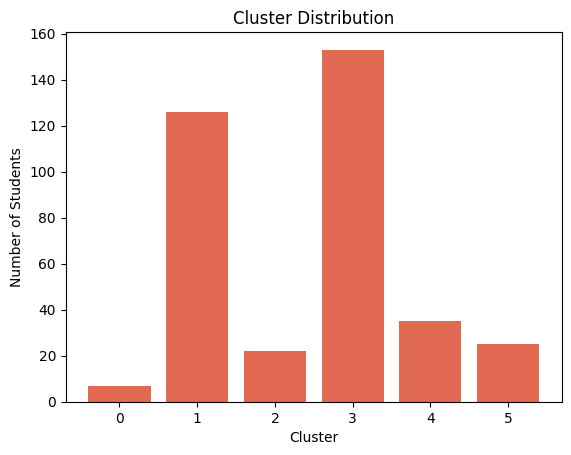

In [173]:
# Create a bar plot to visualize the distribution of clusters
cluster_counts = df['skill_cluster'].value_counts().sort_index()
with sns.color_palette('coolwarm_r'):
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Students')
    plt.title('Cluster Distribution')
    plt.xticks(cluster_counts.index)
    plt.show()

# CLUSTERING STUDENTS BASED ON THEIR CGPA AND TECHNICAL SKILL SCORES

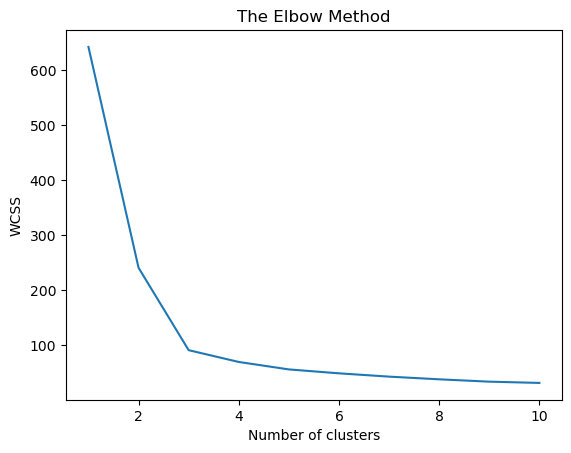

In [7]:
#finding number of clusters
num_cols = ['CGPA', 'avg_tech']
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df[num_cols])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

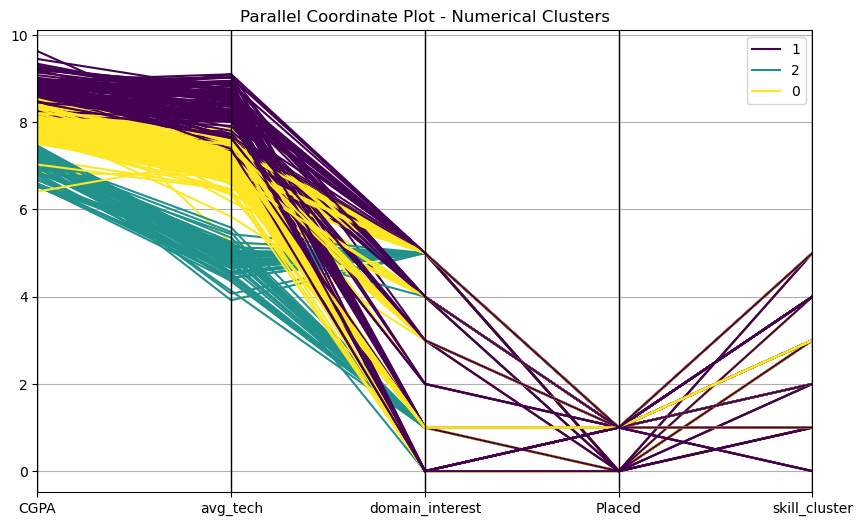

In [11]:
# Clustering the numerical columns (CGPA, avg_tech)
kmeans = KMeans(n_clusters=3, random_state=42)
df['num_cluster'] = kmeans.fit_predict(df[num_cols])


# Parallel Coordinate Plot for visualization
plt.figure(figsize=(10, 6))
parallel_coordinates(df, class_column='num_cluster', colormap='viridis')
plt.title('Parallel Coordinate Plot - Numerical Clusters')
plt.show()




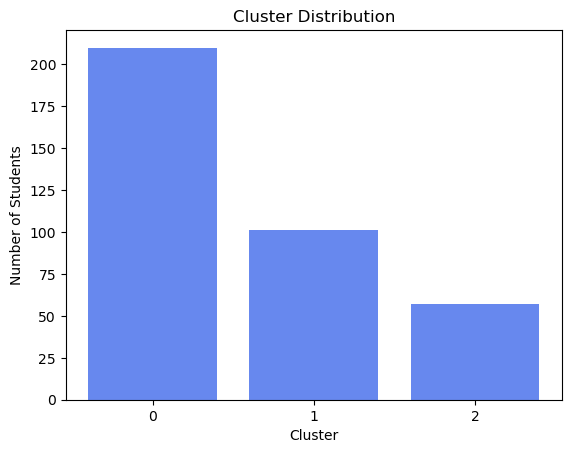

In [12]:
# Create a bar plot to visualize the distribution of clusters
cluster_counts = df['num_cluster'].value_counts().sort_index()
with sns.color_palette('coolwarm'):
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Students')
    plt.title('Cluster Distribution')
    plt.xticks(cluster_counts.index)
    plt.show()

In [16]:
cluster_min_max = {}
# Loop through each cluster
for cluster_label in range(3):
    cluster_data = df[kmeans.labels_ == cluster_label]
    min_values = np.min(cluster_data, axis=0)
    max_values = np.max(cluster_data, axis=0)
    cluster_min_max[cluster_label] = {'min_values': min_values, 'max_values': max_values}

# Print cluster min-max values
for cluster_label, values in cluster_min_max.items():
    print(f"Cluster {cluster_label} - Min Values: \n{values['min_values']},\n\n Max Values:\n {values['max_values']}\n\n")

Cluster 0 - Min Values: 
CGPA               6.410000
avg_tech           5.233333
domain_interest    0.000000
Placed             0.000000
skill_cluster      0.000000
num_cluster        0.000000
dtype: float64,

 Max Values:
 CGPA               9.37
avg_tech           7.85
domain_interest    5.00
Placed             1.00
skill_cluster      5.00
num_cluster        0.00
dtype: float64


Cluster 1 - Min Values: 
CGPA               8.040000
avg_tech           7.352764
domain_interest    0.000000
Placed             0.000000
skill_cluster      0.000000
num_cluster        1.000000
dtype: float64,

 Max Values:
 CGPA               9.63
avg_tech           9.10
domain_interest    5.00
Placed             1.00
skill_cluster      5.00
num_cluster        1.00
dtype: float64


Cluster 2 - Min Values: 
CGPA               6.520000
avg_tech           3.916667
domain_interest    0.000000
Placed             0.000000
skill_cluster      1.000000
num_cluster        2.000000
dtype: float64,

 Max Values:
 CGPA  

* Students in Cluster-2 require special attention, as their CGPA, Average technical scores are lower and also none of them are placed.

* Students in Cluster-0 and Cluster-1 have higher CGPA and Average technical scores ranging from all domains but, still we can see few students are not placed. We can recommend such Students with portfolio projects, courses, and internships that'd help them build their resume.

## PREDICTIONS

In [17]:
pred=kmeans.predict([[9.2,5.4]])
print(f"The Student belongs to Cluster- {pred}")

The Student belongs to Cluster- [0]


In [18]:
pred=kmeans.predict([[8.5,7.6]])
print(f"The Student belongs to Cluster- {pred}")

The Student belongs to Cluster- [1]


In [19]:
pred=kmeans.predict([[6.6,5.4]])
print(f"The Student belongs to Cluster- {pred}")

The Student belongs to Cluster- [2]


## DEPLOYMENT

In [22]:
!pip install -U ibm-watson-machine-learning

In [23]:
from ibm_watson_machine_learning import APIClient

## AUTHENTICATION AND SET SPACE

In [26]:
wml_credentials = {
    "apikey":"e35yQsgw11RBVLMxMePewQUhLQxBMa3Pl_0L4u5x7h-9",
    "url": "https://us-south.ml.cloud.ibm.com"
}

In [27]:
wml_client=APIClient(wml_credentials)

In [28]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
9b63dc53-b4d5-4689-97d9-2c39f287f3e0  cluster placement  2023-08-26T19:16:37.463Z
38ec33dd-6fdb-48c0-80a1-0a06aad359b2  placement          2023-08-26T17:19:16.446Z
------------------------------------  -----------------  ------------------------


,ID,NAME,CREATED
0,9b63dc53-b4d5-4689-97d9-2c39f287f3e0,cluster placement,2023-08-26T19:16:37.463Z
1,38ec33dd-6fdb-48c0-80a1-0a06aad359b2,placement,2023-08-26T17:19:16.446Z


In [29]:
SPACE_ID = "9b63dc53-b4d5-4689-97d9-2c39f287f3e0"

In [30]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [31]:
wml_client.software_specifications.list(100)

-----------------------------  ------------------------------------  ----  ------------------  --------------------------
NAME                           ID                                    TYPE  STATE               REPLACEMENT
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  unsupported         runtime-22.2-py3.10
autoai-ts_rt23.1-py3.10        01ce9391-1a79-5a33-94fb-2e134337f314  base  supported
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base  not_provided
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base  not_provided
tensorflow_rt23.1-py3.10       079a91e0-245f-5269-8926-3c20b28f37dc  base  supported
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  unsupported         runtime-22.2-py3.10
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base  unsupported
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base  unsupported         pytorch-onnx_

,NAME,ID,TYPE,STATE,REPLACEMENT
0,default_py3.6,0062b8c9-8b7d-44a0-a9b9-46c416adcbd9,base,unsupported,runtime-22.2-py3.10
1,autoai-ts_rt23.1-py3.10,01ce9391-1a79-5a33-94fb-2e134337f314,base,supported,
2,kernel-spark3.2-scala2.12,020d69ce-7ac1-5e68-ac1a-31189867356a,base,not_provided,
3,pytorch-onnx_1.3-py3.7-edt,069ea134-3346-5748-b513-49120e15d288,base,not_provided,
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,supported,
...,...,...,...,...,...
95,autoai-kb_3.0-py3.6,d139f196-e04b-5d8b-9140-9a10ca1fa91a,base,unsupported,autoai-kb_rt22.2-py3.10
96,spark-mllib_3.0-py36,d82546d5-dd78-5fbb-9131-2ec309bc56ed,base,unsupported,spark-mllib_3.3
97,autoai-kb_3.4-py3.8,da9b39c3-758c-5a4f-9cfd-457dd4d8c395,base,unsupported,autoai-kb_rt22.2-py3.10
98,kernel-spark3.2-r3.6,db2fe4d6-d641-5d05-9972-73c654c60e0a,base,not_provided,


## SAVE AND DEPLOY

In [32]:
MODEL_NAME = "placement"
DEPLOYMENT_NAME = "cluster placement"
DEMO_MODEL = kmeans

In [33]:
#set python version

software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.2-py3.10')

In [34]:
import sklearn
sklearn.__version__

'1.1.1'

In [35]:
#setup model meta

model_props = {
    wml_client.repository.ModelMetaNames.NAME:MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE:'scikit-learn_1.1',
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

In [38]:
#save model

model_details = wml_client.repository.store_model(
    model = DEMO_MODEL,
    meta_props = model_props,
    training_data = df[num_cols],
    training_target = df['Placed'])

In [39]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'Placed',
  'schemas': {'input': [{'fields': [{'name': 'CGPA', 'type': 'float64'},
      {'name': 'avg_tech', 'type': 'float64'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
   'name': 'runtime-22.2-py3.10'},
  'training_data_references': [{'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'CGPA', 'type': 'float64'},
      {'name': 'avg_tech', 'type': 'float64'}],
     'id': '1',
     'type': 'DataFrame'},
    'type': 'container'}],
  'type': 'scikit-learn_1.1'},
 'metadata': {'created_at': '2023-08-26T19:54:18.015Z',
  'id': '3075aa63-5cad-4f08-a37c-811d80b4a7b3',
  'modified_at': '2023-08-26T19:54:20.298Z',
  'name': 'placement',
  'owner': 'IBMid-691000203P',
  'resource_key': '67f9d173-be5d-41b4-a142-3ec29825a31d',
  'space_id': '9b63dc53-b4d5-4689-97d9-2c39f287f3e0'},
 'system': {'warnings': []}}

In [40]:
model_id=wml_client.repository.get_model_id(model_details)

In [41]:
model_id

'3075aa63-5cad-4f08-a37c-811d80b4a7b3'

In [42]:
#set meta

deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [43]:
#DEPLOY

deployment = wml_client.deployments.create(
    artifact_uid = model_id,
    meta_props = deployment_props)



#######################################################################################

Synchronous deployment creation for uid: '3075aa63-5cad-4f08-a37c-811d80b4a7b3' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='7d7e46d9-20c0-464e-952b-21fb5d3ace6c'
------------------------------------------------------------------------------------------------


